In [1]:
%load_ext autoreload
%autoreload 2

# TransducedLM vs FusedTransducedLM Benchmark

Compares two approaches to computing next-symbol log-probabilities through
an FST on the Penn Treebank tokenizer (~296 states, 257 input symbols):

- **TransducedLM**: two-phase (PeekabooState BFS decomposition, then LM-weighted search)
- **FusedTransducedLM**: single-pass (interleaved decomposition + LM search, no separate BFS)

Uses a 3-gram CharNgramLM as the inner LM, with per-call timeouts and a
process-wide memory limit.

In [2]:
import time, gc
import numpy as np
from transduction.applications.ptb import build_ptb_fst_pynini, decode_ptb_output
from transduction.fsa import EPSILON
from transduction.util import Timeout, timelimit, set_memory_limit
set_memory_limit(8)

In [3]:
t0 = time.perf_counter()
ptb_fst = build_ptb_fst_pynini()
print(f'PTB FST built in {time.perf_counter()-t0:.1f}s: '
      f'{len(ptb_fst.states)} states, |A|={len(ptb_fst.A)}, |B|={len(ptb_fst.B)}')

Composing PTB rules...
Core PTB FST: 310 states
Final pynini FST: 296 states
Converting to native FST...
Native FST: 296 states, 23723 arcs
  eps: 108 in, 352 out
  MARKER: 0 in, 0 out
  [EOS]: 0 in, 0 out
PTB FST built in 32.4s: 296 states, |A|=257, |B|=256


In [4]:
# Generate target sequence via FST.transduce (PTB FST uses integer byte symbols directly)
text = "The quick brown fox jumps over the lazy dog."
target_seq = list(ptb_fst.transduce(text.encode('utf-8')))
decoded = decode_ptb_output(tuple(target_seq))
print(f'Target: {len(target_seq)} symbols')
print(f'  {decoded!r}')

# Train inner LM on integer byte symbols (CharNgramLM works with any hashable type).
# Each sentence is a separate training instance so the model learns EOS.
from transduction.lm.ngram import CharNgramLM
source_alpha = ptb_fst.A - {EPSILON}
train_sentences = [
    "The quick  brown   fox    jumps     over the lazy dog.",
    "A stitch in time saves nine.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Actions speak louder than words.",
    "Practice makes perfect.",
    "Where there is a will, there is a way.",
] * 3
train_instances = [list(s.encode('utf-8')) for s in train_sentences]
inner_lm = CharNgramLM.train(train_instances, n=3, alpha=0.5, alphabet=source_alpha)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Target: 45 symbols
  'The quick brown fox jumps over the lazy dog .'
Inner LM: alphabet=257 symbols


In [5]:
decoded

'The quick brown fox jumps over the lazy dog .'

## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs.  For TransducedLM,
the PeekabooState BFS dominates (~35s per step on PTB).  FusedTransducedLM
avoids the BFS entirely but builds the lazy DFA inline during search.

Both use `K=20`, `max_expansions=200`, with a 120s timeout per step.

In [6]:
from collections import defaultdict
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM

MAX_DECODE = 100             # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 20                # max particles carried forward
LM_TIMEOUT = 3               # seconds per step

# Expected runtime: ~15-20 min total (TransducedLM ~65s/step, FusedTransducedLM ~35s/step)

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

for name, cls in [
    ('TransducedLM', TransducedLM),
#    ('FusedTransducedLM', FusedTransducedLM),
]:
    print(f'\n{name} (K={MAX_BEAM}, max_expansions={MAX_SEARCH}):')
    if cls is TransducedLM:
        tlm = cls(inner_lm, ptb_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH)
    else:
        tlm = cls(inner_lm, ptb_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)
    try:
        with timelimit(LM_TIMEOUT):
            state = tlm.initial()
    except (Timeout, MemoryError) as e:
        print(f'  initial() failed: {type(e).__name__}: {e}')
        continue
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        try:
            with timelimit(LM_TIMEOUT):
                t0 = time.perf_counter()
                lp = state.logp_next[y]
                state = state >> y
                t1 = time.perf_counter()
        except Timeout:
            print(f'  step {i+1} TIMEOUT ({LM_TIMEOUT}s)')
            break
        except MemoryError:
            print(f'  step {i+1} OOM')
            break
        elapsed = t1 - t0
        lm_results[name].append((i + 1, elapsed, lp))
        print(f'  {i+1:2d}: {elapsed*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()


TransducedLM (K=20, max_expansions=200):
   1:    104.9 ms  logp=-4.9133
   2:     31.4 ms  logp=-3.6412
   3:     31.5 ms  logp=-3.6185
   4:    308.8 ms  logp=-2.0301
   5:    150.2 ms  logp=-3.7799
   6:     34.2 ms  logp=-3.0096
   7:     34.7 ms  logp=-3.6286
   8:     36.1 ms  logp=-3.6056
   9:     36.2 ms  logp=-3.6286
  10:    249.8 ms  logp=-2.3225
  11:    156.3 ms  logp=-6.4848
  12:     53.4 ms  logp=-3.6455
  13:     56.6 ms  logp=-3.5997
  14:     60.3 ms  logp=-3.5997
  15:    183.3 ms  logp=-3.6072
  16:    371.9 ms  logp=-2.1254
  17:    236.4 ms  logp=-6.1292
  18:     84.8 ms  logp=-3.5978
  19:    163.5 ms  logp=-3.5978
  20:    215.1 ms  logp=-2.3539
  21:    225.1 ms  logp=-6.8429
  22:    199.2 ms  logp=-3.5978
  23:    101.0 ms  logp=-3.5978
  24:     93.7 ms  logp=-3.5978
  25:    188.4 ms  logp=-3.5978
  26:    244.8 ms  logp=-2.3583
  27:    224.0 ms  logp=-7.0071
  28:    185.3 ms  logp=-3.6204
  29:    100.4 ms  logp=-3.5978
  30:    101.6 ms  logp=-3.620

In [7]:
type(state)

transduction.lm.transduced.TransducedState

In [8]:
# Approximate posterior distribution over source strings given the target prefix.
# TransducedState._repr_html_ groups particles by (source, DFA state),
# normalizes log-weights, and renders an HTML table.
state

TransducedState(target=(84, 104, 101, 258, 113, 117, 105, 99, 107, 258, 98, 114, 111, 119, 110, 258, 102, 111, 120, 258, 106, 117, 109, 112, 115, 258, 111, 118, 101, 114, 258, 116, 104, 101, 258, 108, 97, 122, 121, 258, 100, 111, 103, 258, 46), K=20)

## Particle Inspection

Each particle tracks a DFA state ID (an opaque `u32` integer from the Rust
powerset construction), an LM state, and a log-weight.

In [ ]:
from transduction.viz import _format_source_path

print(f'{len(state._particles)} particles\n')
for i, p in enumerate(state._particles):
    source = _format_source_path(p.lm_state)
    print(f'  particle {i}: dfa_id={p.dfa_state}  w={p.log_weight:.3f}')
    print(f'    source: {source!r}')

### Q/R FSA Visualization

For each target symbol `y`, the decomposition produces a **quotient** FSA Q(y)
(accepts source prefixes where *all* continuations produce `y` next) and a
**remainder** FSA R(y) (the leftover after removing the quotient).

Below we render Q and R for a few symbols, highlighting particle states in
blue.  States are labeled with their decoded NFA sets.

In [ ]:
from IPython.display import display, HTML, SVG

particle_states = {p.dfa_state for p in state._particles}

def fmt_node(s):
    return str(s)

def sty_node(s):
    if s in particle_states:
        return {'fillcolor': '#ADD8E6', 'style': 'filled,rounded'}
    return {}

# Q/R visualization requires a PeekabooState (TransducedState only)
if hasattr(state, '_peekaboo_state'):
    ps = state._peekaboo_state
    decomp = ps.decomp
    shown = 0
    MAX_SHOW = 5
    for y in sorted(decomp.keys(), key=repr):
        if shown >= MAX_SHOW:
            break
        try:
            q_fsa, r_fsa = ps.build_qr_fsa(y)
        except Exception:
            continue
        if not q_fsa.states and not r_fsa.states:
            continue

        y_label = repr(y)
        display(HTML(f'<h4>y = {y_label}</h4>'))
        if q_fsa.states:
            display(HTML(f'<b>Q({y_label})</b> — {len(q_fsa.states)} states'))
            g = q_fsa.graphviz(fmt_node=fmt_node, sty_node=sty_node)
            display(SVG(g._repr_image_svg_xml()))
        if r_fsa.states:
            display(HTML(f'<b>R({y_label})</b> — {len(r_fsa.states)} states'))
            g = r_fsa.graphviz(fmt_node=fmt_node, sty_node=sty_node)
            display(SVG(g._repr_image_svg_xml()))
        shown += 1

    if shown == 0:
        print('No non-trivial Q/R FSAs for current decomposition symbols.')
else:
    print('Q/R FSA visualization not available for FusedTransducedState '
          '(no pre-computed decomposition).')

In [11]:
# Most likely next symbols from this state
logp = state.logp_next
syms = sorted(logp.keys(), key=lambda s: logp[s], reverse=True)[:15]
print(f"{'symbol':>8s}  {'char':>6s}  {'logp':>8s}  {'prob':>8s}")
print("-" * 36)
for s in syms:
    if isinstance(s, int):
        ch = chr(s) if 32 <= s <= 126 else f'\\x{s:02x}'
    else:
        ch = repr(s)
    print(f"{str(s):>8s}  {ch:>6s}  {logp[s]:8.4f}  {np.exp(logp[s]):8.4f}")

  symbol    char      logp      prob
------------------------------------
   <EOS>  '<EOS>'   -0.0216    0.9786
     258   \x102   -3.8652    0.0210
      46       .   -7.7533    0.0004


In [12]:
# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (s)":>12s} {"Steps":>6s}')
print('-' * 55)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data)
    print(f'{name:<25s} {total:10.1f} {avg:12.1f} {len(data):6d}')
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    t0 = sum(t for _, t, _ in d0)
    t1 = sum(t for _, t, _ in d1)
    if t1 > 0:
        print(f'\nFused speedup (overall): {t0/t1:.2f}x')
    # Exclude step 1 (amortization penalty for Fused)
    if len(d0) > 1 and len(d1) > 1:
        t0_skip1 = sum(t for _, t, _ in d0[1:])
        t1_skip1 = sum(t for _, t, _ in d1[1:])
        if t1_skip1 > 0:
            print(f'Fused speedup (step 2+): {t0_skip1/t1_skip1:.2f}x')


Algorithm                  Total (s) Avg/step (s)  Steps
-------------------------------------------------------
TransducedLM                     7.7          0.2     45


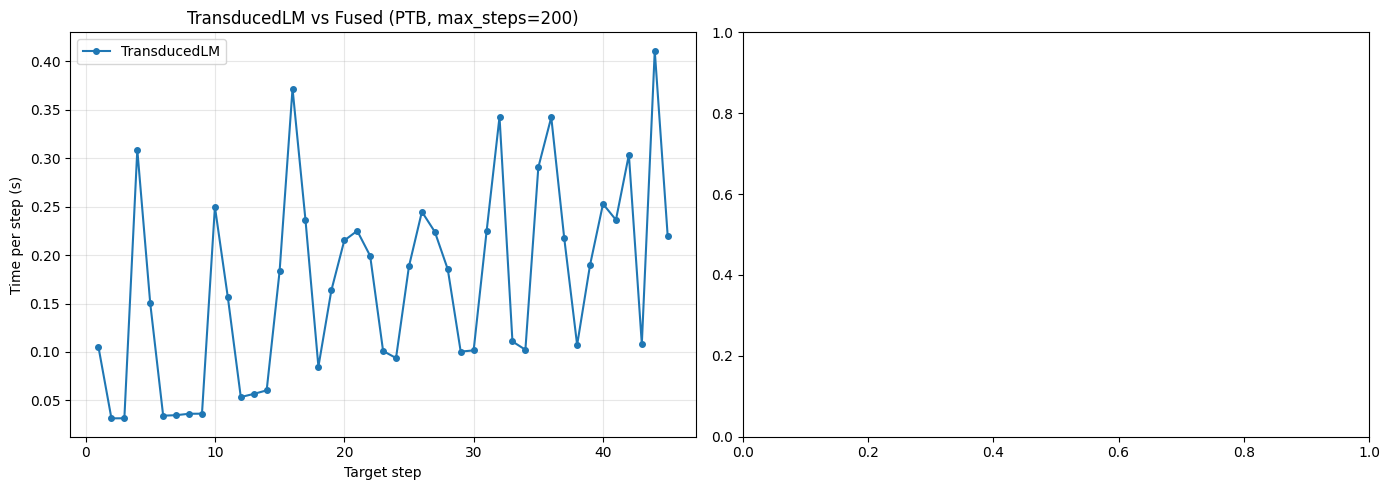

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: time per step
ax = axes[0]
for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] for d in data]
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step')
ax.set_ylabel('Time per step (s)')
ax.set_title(f'TransducedLM vs Fused (PTB, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: per-step speedup
ax = axes[1]
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    n = min(len(d0), len(d1))
    steps = [d0[i][0] for i in range(n)]
    speedups = [d0[i][1] / d1[i][1] if d1[i][1] > 0 else 0 for i in range(n)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    ax.bar(steps, speedups, color=colors, alpha=0.7, edgecolor='white')
    ax.axhline(1.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Target step')
    ax.set_ylabel('Speedup (Original / Fused)')
    ax.set_title('Per-step speedup (>1 = Fused faster)')
    ax.grid(True, alpha=0.3, axis='y')

    logp_diffs = [abs(d0[i][2] - d1[i][2]) for i in range(n)]
    print(f'Max |logp| diff: {max(logp_diffs):.6f}')

plt.tight_layout()
plt.show()